In [1]:
# Import libraries, set some settings

# Useful libraries
import pandas as pd
import numpy as np
import pickle

# Modelling and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
from sklearn.utils import resample

# Black box
from sklearn.svm import SVC

# Visualise
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for the notebook
np.random.seed(0)
pd.options.display.max_columns = None

# Get rid of annoying stuff
import warnings
warnings.simplefilter('ignore')

# SVM Classes
---

We have here 3 different classes that could be used for different purposes, and on different types of data. 

## SVMLinearModel
---

This employs: 

   * Linear Kernel: 
    
        $ K(\vec{x_i},\vec{x_j}) = \vec{x_i} \cdot \vec{x_j} $
    
    
   * Batch Gradient Descent
   * Hinge Loss Function
    
Pros:

   * Works quicker than other methods
   * Acceptable results in high dimensional spaces
    
Cons:

   * Does not capture non-linearities
    
    
## SVMGaussianKernel
---

This employs: 

   * Gaussian / Radial Basis Function Kernel:
   
       $ K(\vec{x_i},\vec{x_j}) = e^{-\gamma (\vec{x_i} - \vec{x_j})^2} $
       
       
   * Sequential Minimal Optimization
   
       * Analytically update 2 Lagrange Multipliers ($\alpha_i$, $\alpha_j$) simultaneously
       * When approximately converged, $\alpha_i$ should automatically stop changing
       
   * Full vectorized Kernel matrix calculation. 
       
Pros: 

   * Vectorized Kernel makes this slightly faster than following method
   * Can easily capture many non-linearities
   
Cons:

   * Easy to overfit
   * Slower than linear model for large amounts of data
   * Memory intensive
   
   
## SVMGaussianKernelModified
---

This employs: 

   * Gaussian / Radial Basis Function Kernel:
   
       $ K(\vec{x_i},\vec{x_j}) = e^{-\gamma (\vec{x_i} - \vec{x_j})^2} $
       
       
   * Sequential Minimal Optimization
   
       * Analytically update 2 Lagrange Multipliers ($\alpha_i$, $\alpha_j$) simultaneously
       * When approximately converged, $\alpha_i$ should automatically stop changing
       
   * Only calculates the portions of the Kernel that are needed. 
       
Pros: 

   * Uses less memory than the previous method
   * Can easily capture many non-linearities
   
Cons:

   * Easy to overfit
   * Slower than linear model for large amounts of data
   * Slower than previous Gaussian method due to multiple Kernel re-calculations

In [2]:
class SVMLinear:
    """
        SVM Class that uses a Linear Kernel and (Batch) Gradient Descent on the Hinge Loss Function.

        Required Parameters for fit call::
        x = Training Data Matrix.
        y = Training Data Classes. This should be size n x 1.

        Optional Parameters: 
        C = 1.0, controls amount of 'slack' allowed. Larger C = less margin violations are allowed. 
        learning_rate = 0.005, controls speed of gradient descent.
        max_iter = 5000, controls number of gradient descent iterations. 

        To Predict On New Data:
        decision_function(x_test) = returns predictions for y, without scaling to +/- 1.
        prediction(x_test) = returns sign(decision_function), will give actual class labels. 
    """

    def __init__(self, C=1.0, learning_rate=0.005, max_iter = 5000):
        self.x = 0
        self.y = 0
        self.learning_rate = learning_rate
        self.n_examples = 0
        self.p_features = 0
        self.slack_variable_c = C
        self.max_iter = max_iter
        self.weights = 0
        self.scalar_bias_term = 0
        print("Initializing...")
        
    def fit(self,x,y):
        self.x = np.mat(x)
        self.y = np.mat(y).reshape(-1,1)
        self.n_examples = self.y.shape[0]
        self.p_features = self.x.shape[1]
        self.weights = np.mat(np.random.rand(self.p_features,1))
        
        if self.max_iter < 10000:
            print("WARNING: Will automatically cut off at ",str(self.max_iter),"iterations")
        print("Training......")
        
        self.gradient_descent()
        
    def calculate_hinge_loss(self, test_data_x, test_data_y):
        margins = np.multiply(test_data_y , self.decision_function(test_data_x))
        weights_sum_of_squares = self.weights.T*self.weights
        list_of_margin_violations = np.maximum(0, 1 - margins)
        margin_penalty = list_of_margin_violations.sum()
        return 0.5 * weights_sum_of_squares + self.slack_variable_c* margin_penalty
    
    def gradient_descent(self):
        for ii in range(self.max_iter):
            
            # Grab the indices for any margins which are less than 1
            # These are data points which violate the SVM's margin lines
            margins = np.multiply(self.y , self.decision_function(self.x))
            idx_of_dataset_that_violated_margin = np.where(margins < 1)[0]
            # Update the vector of weights and the bias term
            #Calc the gradient for W
            gradient_of_weights = self.weights -  self.slack_variable_c*self.x[idx_of_dataset_that_violated_margin].T*self.y[idx_of_dataset_that_violated_margin]
            # update the vector of weights
            self.weights = self.weights - self.learning_rate * gradient_of_weights 
            # Calculate the gradient for the bias term
            gradient_of_bias_term = - self.slack_variable_c*self.y[idx_of_dataset_that_violated_margin].sum() 
            # update the bias term
            self.scalar_bias_term -= self.learning_rate * gradient_of_bias_term

    def decision_function(self,test_data_x):
        # Decision Function f(x)= sum_i alpha_i y_i Kernel(x_i,x) + b
        test_data_x = np.mat(test_data_x)
        decision = test_data_x*self.weights+self.scalar_bias_term
        return decision

    def predict(self, test_data_x):
        decisions = self.decision_function(test_data_x)
        prediction = np.sign(decisions)
        return prediction

    
class SVMGaussianKernel:
    """
        SVM Class that uses the Radial Basis Function/Gaussian Kernel.
        Optimization is done using Sequential Minimal Optimization (SMO) Techniques.
        
        **WARNING**
        This version calculates the FULL kernel to increase the speed of the calculations. 
        As such, this should NOT be used on large data sets (where n x x will be >> memory limitations)

        Required Parameters for fit call:
        x = Training Data Matrix.
        y = Training Data Classes. This should be size n x 1.

        Optional Parameters: 
        C = 1.0, controls amount of 'slack' allowed. Larger C = less margin violations are allowed. 
        gamma = 1.0, controls the 'width' of the kernel distributions. Larger gamma = more overfitting.
        max_iter = 5000, controls number of run throughs of successful alpha changes (similar to gradient descent).
        max_passes = 50, allows for multiple checks of alpha stability (due to random nature of choosing 2 alphas) 
                     before stopping
        tol = 0.01, controls how closely alpha must be within KKT constraints to skip modifications
        alpha_tol = 0.00001, controls how much alpha must move to consider having changed within a loop

        To Predict On New Data:
        decision_function(x_test) = returns predictions for y, without scaling to +/- 1.
        prediction(x_test) = returns sign(decision_function), will give actual class labels. 
    """

    def __init__(self,C=1.0,gamma=1.0,max_iter = 5000 , max_passes = 50 , tol = 0.01  , alpha_tol = 0.00001):
        self.x = 0
        self.y = 0
        self.slack_variable_c = C
        self.kernel_hyper_param_gamma = gamma
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.threshold_for_negligibility_of_alpha_movement = alpha_tol
        self.kernel_gaussian = 0
        self.alpha_vector_of_lagrange_multipliers = 0
        self.scalar_bias_term = 0
        print("Initializing...")
        
    def fit(self,x,y):
        self.x = np.mat(x)
        self.y = np.mat(y).reshape(-1,1)
        self.kernel_gaussian = self.create_kernel(self.x,self.x,self.kernel_hyper_param_gamma)
        self.alpha_vector_of_lagrange_multipliers = np.mat(np.zeros((np.shape(x)[0], 1)))
        
        i = 0
        self.alpha_not_changed_so_increment_toward_max_passes = False
        
        if self.max_iter < 10000:
            print("WARNING: Will automatically cut off at ",str(self.max_iter),"iterations")
        
        print("Training......")
        count = 0
        while (i < self.max_passes) and (count<=self.max_iter):
            # Take one pass of optimization attempts through whole data set
            self.do_one_SMO_pass()
            # If alpha has moved, there is still room for optimizing alpha
            # So reset the counter towards max passes
            if self.alpha_not_changed_so_increment_toward_max_passes:
                i += 1
            # If alpha has stopped moving, start counting towards max_passes
            else:
                i = 0
                count+=1
            if count%1000==0:
                print(count)
    
    def create_kernel(self,x1,x2,gamma):
        # Create a vector of all row magnitudes ^2 
        x1_sum_squared = np.sum(np.multiply(x1,x1),1)
        x2_sum_squared = np.sum(np.multiply(x2,x2),1)
        # Create a matrix for x1 dot x2
        x1_dot_x2 = x1*x2.T
        # Calculate (xi-xj)^2 = (xi^2 + xj^2 - 2 xi dot xj)
        x1_minus_x2_squared = x1_sum_squared + x2_sum_squared.T - 2*x1_dot_x2
        # Create the kernel
        kernel_gaussian = np.exp(-gamma*x1_minus_x2_squared)
        return kernel_gaussian

    def do_one_SMO_pass(self):
        n_changed_alpha = 0
        # Iterate through whole data set

        number_of_rows_in_x = np.shape(self.x)[0]
        for i in range(number_of_rows_in_x):
            element_wise_product_of_y_and_alpha_vectors = np.multiply(self.y, self.alpha_vector_of_lagrange_multipliers)

            # Ei = summation(alpha[m] * y[m] * k[i,m]) +b - y[m]
            error_at_i = element_wise_product_of_y_and_alpha_vectors.T * self.kernel_gaussian[i].T\
                + self.scalar_bias_term - self.y[i]

            #print("Error terms at: ", str(error_at_i))

            # IF (yiEi < -tol AND alpha_i <C) OR (yiEi > tol AND alpha_i > 0):
            if self.check_alpha_fails_to_satisfy_constraints_on_slack_variables(self.alpha_vector_of_lagrange_multipliers[i], error_at_i):
                # Then:

                # Randomly Select a j that is not equal to i by drawing random indices until we get one that isn't i
                draw_another_number = True
                j = int(np.random.uniform(0, number_of_rows_in_x))
                while draw_another_number:
                    if j != i:
                        draw_another_number = False
                    else:
                        j = int(np.random.uniform(0, number_of_rows_in_x))

                # Ei = summation(alpha[m] * y[m] * k[j, m]) + b - y[j]
                error_at_j = element_wise_product_of_y_and_alpha_vectors.T * self.kernel_gaussian[j].T\
                    + self.scalar_bias_term - self.y[j]

                old_ith_element_of_alpha_vector = self.alpha_vector_of_lagrange_multipliers[i].copy()
                old_jth_element_of_alpha_vector = self.alpha_vector_of_lagrange_multipliers[j].copy()

                # Get the upper and lower bounds for alpha
                lower_bound = 0
                upper_bound = 0

                # IF yi != yj :
                if self.y[i] == self.y[j]:
                    # L = max(0,alpha_i + alpha_j - C)
                    lower_bound = max(0,
                                      (old_ith_element_of_alpha_vector + old_jth_element_of_alpha_vector)
                                      - self.slack_variable_c)
                    # H = min(C, alpha_i + alpha_j)
                    upper_bound = min(self.slack_variable_c,
                                      (old_ith_element_of_alpha_vector + old_jth_element_of_alpha_vector))

                else:
                    # L = max(0,alpha_j - alpha_i)
                    lower_bound = \
                        max(0, (old_jth_element_of_alpha_vector - old_ith_element_of_alpha_vector))
                    # H = min(C, C + (alpha_j - alpha_i))
                    upper_bound = \
                        min(self.slack_variable_c,
                            ((old_jth_element_of_alpha_vector - old_ith_element_of_alpha_vector) + self.slack_variable_c))

                # eita = 2K[i,j] - K[i,i] - k[j,j]
                second_derivative_of_dual = 2.0*self.kernel_gaussian[i,j] - self.kernel_gaussian[i,i]\
                    -self.kernel_gaussian[j,j]

                if lower_bound != upper_bound and second_derivative_of_dual < 0:
                    succeeded_at_update_attempt = \
                        self.attempt_to_update_alphas_at_i_and_j(i, j, error_at_i, error_at_j,
                                                                 second_derivative_of_dual,
                                                                 lower_bound,upper_bound,
                                                                 old_ith_element_of_alpha_vector,
                                                                 old_jth_element_of_alpha_vector)
                    if succeeded_at_update_attempt:
                        n_changed_alpha += 1

        # If alpha has moved, there is still room for optimizing alpha
        # So reset the counter towards max passes
        if n_changed_alpha > 0:
            self.alpha_not_changed_so_increment_toward_max_passes = False
        # If alpha has stopped moving, start counting towards towards max_passes
        else:
            self.alpha_not_changed_so_increment_toward_max_passes = True
        return

    def attempt_to_update_alphas_at_i_and_j(self, i, j, error_at_i, error_at_j, eita,
                                            lower_bound, upper_bound, old_alpha_i, old_alpha_j):
        succeeded_at_attempt_to_optimize = False

        # From Lindsay PDF: distance to move = yj(Ei-Ej)/eita
        how_far_to_move_alpha_j = self.y[j] * (error_at_i - error_at_j) / eita

        self.alpha_vector_of_lagrange_multipliers[j] -= how_far_to_move_alpha_j

        # IF alpha j has tried to go outside the bounds, reel it back in
        if self.alpha_vector_of_lagrange_multipliers[j] < lower_bound:
            self.alpha_vector_of_lagrange_multipliers[j] = lower_bound
        if self.alpha_vector_of_lagrange_multipliers[j] > upper_bound:
            self.alpha_vector_of_lagrange_multipliers[j] = upper_bound

        alpha_j_movement_since_old_alpha_j = self.alpha_vector_of_lagrange_multipliers[j] - old_alpha_j

        # If alpha only moved by an insignificant amount, don't count it as a movement
        if abs(alpha_j_movement_since_old_alpha_j) >= self.threshold_for_negligibility_of_alpha_movement:
            # Else: From Lindsay PDF: alpha = old_alpha_i + yiyi + (old_alpha_j - new_alpha_j)
            self.alpha_vector_of_lagrange_multipliers[i] += self.y[j] * self.y[i] * (
                    old_alpha_j - self.alpha_vector_of_lagrange_multipliers[j])

            #Update the bias term b

            last_movement_of_alpha_i = self.alpha_vector_of_lagrange_multipliers[i] - old_alpha_i
            last_movement_of_alpha_j = self.alpha_vector_of_lagrange_multipliers[j] - old_alpha_j

            # From Lindsay PDF: definitions for bi and bj
            b1 = self.scalar_bias_term - error_at_i - self.y[i] * last_movement_of_alpha_i * self.kernel_gaussian[i,i] \
                 - self.y[j] * last_movement_of_alpha_j * self.kernel_gaussian[i,j]

            b2 = self.scalar_bias_term - error_at_j - self.y[i] * last_movement_of_alpha_i * self.kernel_gaussian[i,j] \
                 - self.y[j] * last_movement_of_alpha_j * self.kernel_gaussian[j,j]

            if (0 < self.alpha_vector_of_lagrange_multipliers[i]) and \
                    (self.slack_variable_c > self.alpha_vector_of_lagrange_multipliers[i]):
                self.scalar_bias_term = b1
            elif (0 < self.alpha_vector_of_lagrange_multipliers[j]) and \
                    (self.slack_variable_c > self.alpha_vector_of_lagrange_multipliers[j]):
                self.scalar_bias_term = b2
            else:
                # From Lindsay PDF: b = (bi+bj)/2 bottom of page 3
                self.scalar_bias_term = (b1 + b2) / 2.0


            succeeded_at_attempt_to_optimize = True

        return succeeded_at_attempt_to_optimize

    def check_alpha_fails_to_satisfy_constraints_on_slack_variables(self, alpha, E):
        if (np.abs(E) < self.tol) and (alpha > 0):
            return True
        elif alpha < self.slack_variable_c and np.abs(E) > self.tol:
            return True
        else:
            return False
        
    def decision_function(self,test_data_x):
        test_data_x = np.mat(test_data_x)
        kernel_for_test = self.create_kernel(test_data_x,self.x,self.kernel_hyper_param_gamma)
        element_wise_product_of_y_and_alpha_vectors = np.multiply(self.y, self.alpha_vector_of_lagrange_multipliers)
        decisions = kernel_for_test*element_wise_product_of_y_and_alpha_vectors + self.scalar_bias_term
        return decisions

    def predict(self, test_data_x):
        decisions = self.decision_function(test_data_x)
        prediction = np.sign(decisions)
        return prediction
    
    def load_weights_and_settings(self,name):
        print("Loading pre-trained file and settings......")
        file_input_stream = open(name, 'rb')
        trained_weights = pickle.load(file_input_stream)
        file_input_stream.close()          
        self.__dict__.update(trained_weights)
        print("Model loaded successfully")
        print("Gamma = ",self.kernel_hyper_param_gamma)
        print("max_iter = ",self.max_iter)
        
    def save_weights_and_settings(self,name_to_use):
        print("Saving Model.....")
        file_input_stream = open(name_to_use, 'wb')
        pickle.dump(self.__dict__, file_input_stream, 2)
        file_input_stream.close()
        print("Model saved as: ",name_to_use)
        

class SVMGaussianKernelModified:
    """
        SVM Class that uses the Radial Basis Function/Gaussian Kernel.
        Optimization is done using Sequential Minimal Optimization (SMO) Techniques.
        
        **WARNING**
        This version calculates one column of kernel to decrease the memory load of the calculations. 
        As such, this will likely move slowly on large datasets.

        Required Parameters for fit call:
        x = Training Data Matrix.
        y = Training Data Classes. This should be size n x 1.

        Optional Parameters: 
        C = 1.0, controls amount of 'slack' allowed. Larger C = less margin violations are allowed. 
        gamma = 1.0, controls the 'width' of the kernel distributions. Larger gamma = more overfitting.
        max_iter = 5000, controls number of run throughs of successful alpha changes (similar to gradient descent).
        max_passes = 50, allows for multiple checks of alpha stability (due to random nature of choosing 2 alphas) 
                     before stopping
        tol = 0.01, controls how closely alpha must be within KKT constraints to skip modifications
        alpha_tol = 0.00001, controls how much alpha must move to consider having changed within a loop

        To Predict On New Data:
        decision_function(x_test) = returns predictions for y, without scaling to +/- 1.
        prediction(x_test) = returns sign(decision_function), will give actual class labels. 
    """

    def __init__(self,C=1.0,gamma=1.0,max_iter = 5000 , max_passes = 20 , tol = 0.01  , alpha_tol = 0.00001):
        self.x = 0
        self.y = 0
        self.slack_variable_c = C
        self.kernel_hyper_param_gamma = gamma
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.threshold_for_negligibility_of_alpha_movement = alpha_tol
        self.alpha_vector_of_lagrange_multipliers = 0
        self.scalar_bias_term = 0
        print("Initializing...")
        
    def fit(self,x,y):
        self.x = np.mat(x)
        self.y = np.mat(y).reshape(-1,1)
        self.alpha_vector_of_lagrange_multipliers = np.mat(np.zeros((np.shape(x)[0], 1)))
        
        i = 0
        self.alpha_not_changed_so_increment_toward_max_passes = False
        
        if self.max_iter < 10000:
            print("WARNING: Will automatically cut off at ",str(self.max_iter),"iterations")
        
        print("Training......")
        count = 0
        while (i < self.max_passes) and (count<=self.max_iter):
            # Take one pass of optimization attempts through whole data set
            self.do_one_SMO_pass()
            # If alpha has moved, there is still room for optimizing alpha
            # So reset the counter towards max passes
            if self.alpha_not_changed_so_increment_toward_max_passes:
                i += 1
            # If alpha has stopped moving, start counting towards max_passes
            else:
                i = 0
                count+=1
            if count%1000==0:
                print(count)
    
    def create_kernel(self,x1,x2):
        # Create a vector of all row magnitudes ^2 
        x1_sum_squared = np.sum(np.multiply(x1,x1),1)
        x2_sum_squared = np.sum(np.multiply(x2,x2),1)
        # Create a matrix for x1 dot x2
        x1_dot_x2 = x1*x2.T
        # Calculate (xi-xj)^2 = (xi^2 + xj^2 - 2 xi dot xj)
        x1_minus_x2_squared = x1_sum_squared + x2_sum_squared.T - 2*x1_dot_x2
        # Create the kernel
        kernel_gaussian = np.exp(-self.kernel_hyper_param_gamma*x1_minus_x2_squared)
        return kernel_gaussian
    
    def calculate_error_i(self,idx):
        # Ei = summation(alpha[m] * y[m] * k[i,m]) +b - y[m]
        element_wise_product_of_y_and_alpha_vectors = np.multiply(self.y, self.alpha_vector_of_lagrange_multipliers)
        # Calculate single column of the kernel matrix as needed
        kernel_m_i = self.create_kernel(self.x,self.x[idx])
       # print(kernel_m_i)
        #print(element_wise_product_of_y_and_alpha_vectors.T.shape, kernel_m_i.shape)
        error_at_i = element_wise_product_of_y_and_alpha_vectors.T @ kernel_m_i
        #print(error_at_i)
        error_at_i = error_at_i + self.scalar_bias_term - self.y[idx]
        return error_at_i

    def do_one_SMO_pass(self):
        n_changed_alpha = 0
        # Iterate through whole data set

        number_of_rows_in_x = np.shape(self.x)[0]
        for i in range(number_of_rows_in_x):
            #element_wise_product_of_y_and_alpha_vectors = np.multiply(self.y, self.alpha_vector_of_lagrange_multipliers)

            # Ei = summation(alpha[m] * y[m] * k[i,m]) +b - y[m]
            error_at_i = self.calculate_error_i(i)

            #print("Error terms at: ", str(error_at_i))

            # IF (yiEi < -tol AND alpha_i <C) OR (yiEi > tol AND alpha_i > 0):
            if self.check_alpha_fails_to_satisfy_constraints_on_slack_variables(self.alpha_vector_of_lagrange_multipliers[i], error_at_i):
                # Then:

                # Randomly Select a j that is not equal to i by drawing random indices until we get one that isn't i
                draw_another_number = True
                j = int(np.random.uniform(0, number_of_rows_in_x))
                while draw_another_number:
                    if j != i:
                        draw_another_number = False
                    else:
                        j = int(np.random.uniform(0, number_of_rows_in_x))

                # Ei = summation(alpha[m] * y[m] * k[j, m]) + b - y[j]
                error_at_j = self.calculate_error_i(j)
                
                old_ith_element_of_alpha_vector = self.alpha_vector_of_lagrange_multipliers[i].copy()
                old_jth_element_of_alpha_vector = self.alpha_vector_of_lagrange_multipliers[j].copy()

                # Get the upper and lower bounds for alpha
                lower_bound = 0
                upper_bound = 0

                # IF yi != yj :
                if self.y[i] == self.y[j]:
                    # L = max(0,alpha_i + alpha_j - C)
                    lower_bound = max(0,
                                      (old_ith_element_of_alpha_vector + old_jth_element_of_alpha_vector)
                                      - self.slack_variable_c)
                    # H = min(C, alpha_i + alpha_j)
                    upper_bound = min(self.slack_variable_c,
                                      (old_ith_element_of_alpha_vector + old_jth_element_of_alpha_vector))


                else:
                    # L = max(0,alpha_j - alpha_i)
                    lower_bound = \
                        max(0, (old_jth_element_of_alpha_vector - old_ith_element_of_alpha_vector))
                    # H = min(C, C + (alpha_j - alpha_i))
                    upper_bound = \
                        min(self.slack_variable_c,
                            ((old_jth_element_of_alpha_vector - old_ith_element_of_alpha_vector) + self.slack_variable_c))

                # eita = 2K[i,j] - K[i,i] - k[j,j]
                kernel_i_j = self.create_kernel(self.x[i],self.x[j])[0,0]
                kernel_i_i = 1
                kernel_j_j = 1
                second_derivative_of_dual = 2.0*kernel_i_j - kernel_i_i\
                    -kernel_j_j

                if lower_bound != upper_bound and second_derivative_of_dual < 0:
                    succeeded_at_update_attempt = \
                        self.attempt_to_update_alphas_at_i_and_j(i, j, error_at_i, error_at_j,
                                                                 second_derivative_of_dual,
                                                                 lower_bound,upper_bound,
                                                                 old_ith_element_of_alpha_vector,
                                                                 old_jth_element_of_alpha_vector)
                    if succeeded_at_update_attempt:
                        n_changed_alpha += 1

        # If alpha has moved, there is still room for optimizing alpha
        # So reset the counter towards max passes
        if n_changed_alpha > 0:
            self.alpha_not_changed_so_increment_toward_max_passes = False
        # If alpha has stopped moving, start counting towards towards max_passes
        else:
            self.alpha_not_changed_so_increment_toward_max_passes = True
        return

    def attempt_to_update_alphas_at_i_and_j(self, i, j, error_at_i, error_at_j, eita,
                                            lower_bound, upper_bound, old_alpha_i, old_alpha_j):
        succeeded_at_attempt_to_optimize = False
        kernel_i_j = self.create_kernel(self.x[i],self.x[j])[0,0]
        kernel_i_i = 1
        kernel_j_j = 1
        # From Lindsay PDF: distance to move = yj(Ei-Ej)/eita
        how_far_to_move_alpha_j = self.y[j] * (error_at_i - error_at_j) / eita

        self.alpha_vector_of_lagrange_multipliers[j] -= how_far_to_move_alpha_j

        # IF alpha j has tried to go outside the bounds, reel it back in
        if self.alpha_vector_of_lagrange_multipliers[j] < lower_bound:
            self.alpha_vector_of_lagrange_multipliers[j] = lower_bound
        if self.alpha_vector_of_lagrange_multipliers[j] > upper_bound:
            self.alpha_vector_of_lagrange_multipliers[j] = upper_bound

        alpha_j_movement_since_old_alpha_j = self.alpha_vector_of_lagrange_multipliers[j] - old_alpha_j

        # If alpha only moved by an insignificant amount, don't count it as a movement
        if abs(alpha_j_movement_since_old_alpha_j) >= self.threshold_for_negligibility_of_alpha_movement:
            # Else: From Lindsay PDF: alpha = old_alpha_i + yiyi + (old_alpha_j - new_alpha_j)
            self.alpha_vector_of_lagrange_multipliers[i] += self.y[j] * self.y[i] * (
                    old_alpha_j - self.alpha_vector_of_lagrange_multipliers[j])

            #Update the bias term b

            last_movement_of_alpha_i = self.alpha_vector_of_lagrange_multipliers[i] - old_alpha_i
            last_movement_of_alpha_j = self.alpha_vector_of_lagrange_multipliers[j] - old_alpha_j

            # From Lindsay PDF: definitions for bi and bj
            b1 = self.scalar_bias_term - error_at_i - self.y[i] * last_movement_of_alpha_i * kernel_i_i \
                 - self.y[j] * last_movement_of_alpha_j * kernel_i_j

            b2 = self.scalar_bias_term - error_at_j - self.y[i] * last_movement_of_alpha_i * kernel_i_j \
                 - self.y[j] * last_movement_of_alpha_j * kernel_j_j

            if (0 < self.alpha_vector_of_lagrange_multipliers[i]) and \
                    (self.slack_variable_c > self.alpha_vector_of_lagrange_multipliers[i]):
                self.scalar_bias_term = b1
            elif (0 < self.alpha_vector_of_lagrange_multipliers[j]) and \
                    (self.slack_variable_c > self.alpha_vector_of_lagrange_multipliers[j]):
                self.scalar_bias_term = b2
            else:
                # From Lindsay PDF: b = (bi+bj)/2 bottom of page 3
                self.scalar_bias_term = (b1 + b2) / 2.0


            succeeded_at_attempt_to_optimize = True

        return succeeded_at_attempt_to_optimize

    def check_alpha_fails_to_satisfy_constraints_on_slack_variables(self, alpha, E):
        #print(E)
        #print(alpha)
        if (np.abs(E) < self.tol) and (alpha > 0):
            return True
        elif alpha < self.slack_variable_c and np.abs(E) > self.tol:
            return True
        else:
            return False
        
    def decision_function(self,test_data_x):
        # Decision Function f(x)= sum_i alpha_i y_i Kernel(x_i,x) + b
        test_data_x = np.mat(test_data_x)
        n_test = test_data_x.shape[0]
        n_fit = self.x.shape[0]
        
        element_wise_product_of_y_and_alpha_vectors = np.multiply(self.y, self.alpha_vector_of_lagrange_multipliers)
        decisions = np.mat(np.zeros(n_test)).T
        for jj in range(n_test):
            kernel_i_j = self.create_kernel(self.x,test_data_x[jj])
            decisions[jj] = element_wise_product_of_y_and_alpha_vectors.T*kernel_i_j
        
        decisions = decisions +  self.scalar_bias_term
        return decisions

    def predict(self, test_data_x):
        decisions = self.decision_function(test_data_x)
        prediction = np.sign(decisions)
        return prediction
    
    def load_weights_and_settings(self,name):
        print("Loading pre-trained file and settings......")
        file_input_stream = open(name, 'rb')
        trained_weights = pickle.load(file_input_stream)
        file_input_stream.close()          
        self.__dict__.update(trained_weights)
        print("Model loaded successfully")
        print("Gamma = ",self.kernel_hyper_param_gamma)
        print("max_iter = ",self.max_iter)
        
    def save_weights_and_settings(self,name_to_use):
        print("Saving Model.....")
        file_input_stream = open(name_to_use, 'wb')
        pickle.dump(self.__dict__, file_input_stream, 2)
        file_input_stream.close()
        print("Model saved as: ",name_to_use)

# Support Classes
---

The next few classes will help us to assess and validate our model. 

## ModelMetrics

This simply returns a bunch of useful classification metrics:

   * Accuracy
   * Confusion Matrix:
   
       $ \left( \begin{array}{cc}
            \text{True Negative} & \text{False Positive} \\
            \text{False Negative} & \text{True Positive} \\
            \end{array} \right) $
            
            
   * ROC Curve + AUC
       * Most useful when classes are fairly balanced, otherwise it can give a skewed representation. 
       * Plot of True Positive Rate vs False Positive Rate
       * True Positive Rate = Sensitivity = Recall = Probability of Detection
       * Measure of how many are positive that should be.
       
           * $ \frac{TP}{TP + FN} = \frac{TP}{True P} $ 
           
       * False Positive Rate = 1 - Specificity 
       * Measure of how many are positive that shouldn't be. 
       
           * $ \frac{FP}{TN + FN} = \frac{FP}{True N} $
           
   * Precision Recall Curve + PR Metrics:
       * More realistic representation of accuracy when classes are skewed. 
       * Precision = how many are predicted positive correctly out of how many are predicted positive.
       
           * $ \frac{TP}{TP + FP} = \frac{TP}{Predict P} $  
           
       * Recall = Sensitivity = how many are predicted positive out of how many are actually positive. 
       
           * $ \frac{TP}{TP + FN} = \frac{TP}{True P}$ 
           
       * F1 Score = harmonic average of precision and recall, helps to measure skewed data. 
       
           * $ \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} $    
           
       * AUC of PR Curve
       * Average Precision
       
## kFoldsTest

This will do a k folds test on a classification method:

* Split data up into K partitions
* Leave one partition out each training set
* Train on K-1 partitions, test on the last
* Average overall metric score over all K-folds
* If that is the best metric score for a given hyperparameter set, save them and the corresponding model

## Bootstrap

This creates a bootstrap model:

* Is told amount of positive and negative data to include
* Is told number of models to put in the bag
* Randomly selects positive and negative training data for each model
* Fits to each randomized data set, adds to the bag
* Can do predictions at the end based on average prediction of all models

In [3]:
class ModelMetrics():
    """
        ModelMetrics class that will provide many different metrics for a given model outputs. 

        Required Parameters:
        y_test = Test Data Classes. Should be either (-1,1) or (0,1).
        y_pred = Predictions for the "probability" of y being in the positive class. Should be in range (-inf,inf)
        y_prob = Test Data Predictions from the model. Should be same format as y_test. 

        Useful functions:
        all_metrics() = returns metrics including: class imbalance, 
                                                   accuracy,
                                                   confusion matrix,
                                                   ROC/AUC,
                                                   Precision/Recall Curve, F1 score, AUC, Average Precision
        
    """
    
    def __init__(self,y_test,y_pred,y_prob):
        self.y_test = np.array(y_test).reshape(-1)
        self.y_pred = np.array(y_pred).reshape(-1)
        self.y_prob = np.array(y_prob).reshape(-1)
        
    def all_metrics(self):
        print('')
        self.imbalance()
        print('')
        self.accuracy()
        print('')
        self.print_cm()
        print('')
        self.roc_metrics()
        print('')
        self.pr_metrics()
        
    def roc_metrics(self):
        self.roc_plot()
        self.print_auc_roc()
        
    def pr_metrics(self):
        self.plot_pr()
        self.print_f1()
        self.print_auc_pr()
        self.print_ap()
        
    # Measure Imbalance
    def imbalance(self):
        num_examples = len(self.y_test)
        num_neg = np.sum(self.y_test==-1)
        num_pos = np.sum(self.y_test==+1)
        print("Number of -1 cases = ",num_neg)
        print("Number of +1 cases = ",num_pos)
        print('The ratio of Positve to Negative cases is {:0.3f}'.format(num_pos/num_neg))
        
        print('')
        if num_neg/num_pos >= 2:
            print('Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.')
        elif num_pos/num_neg >=2:
            print('Number of Positive Classes is quite large. Recommend using the Precision-Recall Metrics.')
        else:
            print('The classes seem balanced. ROC metrics should be acceptable.')
        print('')
    
    # Overall accuracy
    def accuracy(self):
        acc = accuracy_score(self.y_test,self.y_pred)
        print('Overall Accuracy = {:0.3f}'.format(acc))
        return acc
        
    # Confusion Matrix
    def print_cm(self):
        cm = confusion_matrix(self.y_test,self.y_pred)
        true_negative, false_positive, false_negative, true_positive = cm.ravel()
        print('           CONFUSION MATRIX')
        print('                 y_pred')
        print('          {:^10d}{:^10d}'.format(-1,1))
        print('           --------------------')
        print('y_test -1 |{:^10d}{:^10d}|'.format(true_negative,false_positive))
        print('        1 |{:^10d}{:^10d}|'.format(false_negative,true_positive))
        print('           --------------------')
        return cm
        
    # ROC Curve
    def roc_plot(self):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(self.y_test,self.y_prob)
        plt.plot(false_positive_rate,true_positive_rate,'-b',label='Model')
        plt.plot([0,1],[0,1],'-k',label='Guess')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # AUC of ROC
    def print_auc_roc(self):
        auc1 = roc_auc_score(self.y_test,self.y_prob)
        print('AUC = {:0.3f}'.format(auc1))
        return auc1

    ## These next few are more useful for imbalanced classes 

    # Precision - Recall Curve
    def plot_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        plt.plot(recall,precision,'-b',label='Model')
        plt.plot([0,1],[0.5,0.5],'-k',label='Guess')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # F1 Score
    def print_f1(self):
        f1 = f1_score(self.y_test,self.y_pred)
        print("F1 Score = {:0.3f}".format(f1))
        return f1

    # AUC for PR
    def print_auc_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        auc2 = auc(recall,precision)
        print("AUC for Precision-Recall: {:0.3f}".format(auc2))
        return auc2

    # Average precision
    def print_ap(self):
        average_precision = average_precision_score(self.y_test,self.y_prob)
        print("Average Precision = {:0.3f}".format(average_precision))
        return average_precision
    

class kFoldsTest():
    """
        kFoldsTest class that will provide the best C, gamma parameters for an SVM. 

        Required Parameters:
        x = Input Data
        y = Input Classes
        
        Optional Parameters:
        n_splits = 10, number of k-folds to do
        metric = accuracy_score, metric to use to decide on 'best' model 
                 (must be of form metric(y_test,y_pred)

        Useful functions:
        get_best(C_list,gamma_list,className,max_iter = 5000)
            returns best C, gamma values for a gaussian SVM
            ANY SVM class that uses C, gamma, and max_iter as variables AND
            calls class.fit(x,y), class.predict(x) will work
        
    """
    def __init__(self,x,y,n_splits = 10,metric = accuracy_score):
        self.x_data = x
        self.y_data = y
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits,shuffle=True)
        self.kf.get_n_splits(self.x_data)
        self.metric = metric
        self.C_best = 1
        self.gamma_best = 1
        self.acc_best = 0
        self.model_best = 0

    def get_best(self,C_list,gamma_list,className,max_iter = 5000):

        for C in C_list:
            for gamma in gamma_list:
                # For each value of C and gamma, come up with a new value, and compare with the best current accuracy
                print('C = {:0.2f} and gamma = {:0.2f}'.format(C,gamma))
                acc_list = np.empty(self.n_splits)
                count = 0
                for train_index, test_index in self.kf.split(self.x_data):   
                    x_train, x_test = self.x_data[train_index], self.x_data[test_index]
                    y_train, y_test = self.y_data[train_index], self.y_data[test_index]
                    model = className(C = C, gamma = gamma, max_iter = max_iter)
                    model.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    accuracy_k = self.metric(y_test,y_pred)
                    acc_list[count] = accuracy_k
                    count+=1

                accuracy = np.mean(acc_list)
                print('Done. "Accuracy" was {:0.2f}%\n'.format(100*accuracy))
                if accuracy>self.acc_best:
                    self.acc_best=accuracy
                    self.gamma_best=gamma
                    self.C_best = C
                    self.model_best = model

        print('The best value of C was ',self.C_best)
        print('The best value of gamma was ',self.gamma_best)
        return self.C_best, self.gamma_best, self.model_best
    
    
class Bootstrap():
    """
        Bootstrap class that will produce a set of models to average over. 

        Optional Parameters:
        n_train_pos = 1000, number of positive examples to include
        n_train_neg = 10000, number of negative examples to include
        n_models = 15, number of models to create (should be odd)
        className = SVMGaussianKernelModified, name of class to fit
        gamma = 1.0
        C = 1.0
        max_iter = 500

        Useful functions:
        fit(df,xlist,target) = fits a dataframe with X taken from columns in xlist, y has column name target
        predict(x_test) = makes an overall prediction for what the final output should be
        
    """
    def __init__(self,n_train_pos = 1000,n_train_neg = 10000,n_models = 15, \
                 className = SVMGaussianKernelModified, gamma = 1.0, C = 1.0, max_iter = 500):
        self.n_train_pos = n_train_pos
        self.n_train_neg = n_train_neg
        self.n_models = n_models
        self.className = className
        self.gamma = gamma
        self.C = C
        self.max_iter = max_iter
        self.models = []
    
    def fit(self,df, xlist, target):
        # Split into 2 df with only +/- 
        # xlist is a list of columns to include in the x table
        # target is the name of the row that has the output Y column
        df_pos = df[df[target] == +1]
        df_neg = df[df[target] == -1]
        n_all_pos = df_pos.shape[0]
        n_all_neg = df_neg.shape[0]
        
        # Train each model on a subset of the data
        for ii in range(self.n_models):
            print("TRAINING MODEL ",ii+1)

            # Create training data for the bootstrap
            idx_pos_list_shuffled = np.random.permutation(n_all_pos)
            idx_neg_list_shuffled = np.random.permutation(n_all_neg)

            idx_pos_train = idx_pos_list_shuffled[0:self.n_train_pos]
            idx_neg_train = idx_neg_list_shuffled[0:self.n_train_neg]

            df_train_pos = df_pos.iloc[idx_pos_train,:]
            df_train_neg = df_neg.iloc[idx_neg_train,:]
            df_train = pd.concat([df_train_pos,df_train_neg])
            df_train = df_train.sort_index()

            x_train = np.array(df_train.iloc[:,xlist].values)
            y_train = np.array(df_train[target].values)
            
            # Create the new model and add it to the bootstrap
            self.add_model(x_train,y_train)

    def add_model(self,x_train,y_train):
        model = self.className(C = self.C,gamma = self.gamma,max_iter = self.max_iter)
        model.fit(x_train,y_train)
        self.models.append(model)
        
    def predict(self,x_test):
        n_data = x_test.shape[0]
        y_pred_list = np.mat(np.empty([n_data,self.n_models]))
        for ii in range(self.n_models):
            print("PREDICTING MODEL ",ii+1)
            model = self.models[ii]
            y_pred_ii = np.mat(model.predict(x_test)).reshape(-1,1)
            y_pred_list[:,ii] = y_pred_ii

        y_prob = np.sum(y_pred_list,1)
        y_pred = np.sign(y_prob)
        
        return y_prob,y_pred

class BootstrapKFolds():
    """
        Bootstrap class that will produce a set of models to average over. 
        Uses KFolds at each step to choose optimal hyperparameters for each submodel.

        Optional Parameters:
        n_train_pos = 1000, number of positive examples to include
        n_train_neg = 10000, number of negative examples to include
        n_models = 15, number of models to create (should be odd)
        n_splits = 10, number of splits for k-folds
        metric = accuracy_score, metric to use to choose best hyperparameters
        className = SVMGaussianKernelModified, name of class to fit
        max_iter = 500

        Useful functions:
        fit(df,xlist,target) = fits a dataframe with X taken from columns in xlist, y has column name target
        predict(x_test) = makes an overall prediction for what the final output should be
        
    """
    def __init__(self,n_models = 15,n_splits = 10, n_samples = 10000, metric = accuracy_score,\
                 className = SVMGaussianKernelModified, gamma_list = [0.1,0.3,1,3,10], C_list = [0.1,0.3,1,3,10], max_iter = 500):
        self.n_splits = n_splits
        self.n_models = n_models
        self.n_samples = n_samples
        self.metric = metric
        self.className = className
        self.gamma_list = gamma_list
        self.C_list = C_list
        self.max_iter = max_iter
        self.models = []
    
    def fit(self,x_train,y_train):
        # Split into 2 df with only +/- 
        # xlist is a list of columns to include in the x table
        # target is the name of the row that has the output Y column
        
        # Train each model on a subset of the data
        for ii in range(self.n_models):
            print("TRAINING MODEL ",ii+1)

            # Create training data for the bootstrap
            x_sample, y_sample = resample(x_train,y_train,n_samples = self.n_samples)
            
            # Create the new model and add it to the bootstrap
            self.add_model(x_sample,y_sample)

    def add_model(self,x_train,y_train):
        kfolds = kFoldsTest(x_train,y_train,n_splits = self.n_splits,metric = self.metric)
        C_best, gamma_best, model_best = kfolds.get_best(C_list = self.C_list, gamma_list = self.gamma_list, \
                                                className = self.className,max_iter = self.max_iter)
        model = self.className(C = C_best,gamma = gamma_best,max_iter = self.max_iter)
        model.fit(x_train,y_train)
        self.models.append(model)
        
    def predict(self,x_test):
        n_data = x_test.shape[0]
        y_pred_list = np.mat(np.empty([n_data,self.n_models]))
        for ii in range(self.n_models):
            print("PREDICTING MODEL ",ii+1)
            model = self.models[ii]
            y_pred_ii = np.mat(model.predict(x_test)).reshape(-1,1)
            y_pred_list[:,ii] = y_pred_ii

        y_prob = np.sum(y_pred_list,1)
        y_pred = np.sign(y_prob)
        
        return y_prob,y_pred


# Miniboone Data and Actually Testing Things

In [6]:
# Create DF 

# Important Values
n_signal = 36499
n_bkgd = 93565
n_features = 50

# Read in all the data 
data = pd.read_csv('../Data/MiniBooNE_PID.txt', sep='\s+', skiprows=1,header=None)
pd.options.display.max_columns = None

# Scale and append signal/background cases
scaler = StandardScaler()
data = data[data>-999] # Get rid of bad data, set to NA
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))

data_sig = data.iloc[0:n_signal,:]
data_sig.dropna(inplace=True)

data_bkgd = data.iloc[n_signal:,:]
#data_bkgd = data_bkgd[data_bkgd>-999]
data_bkgd.dropna(inplace=True)

# Add a column of 1s for signal and 0s for background
n_sig_new = data_sig.shape[0]
n_bkgd_new = data_bkgd.shape[0]
data_sig = data_sig.assign(target=np.ones((n_sig_new,1)))
data_bkgd = data_bkgd.assign(target=-np.ones((n_bkgd_new,1)))
data_full = data_sig.append(data_bkgd)

# All data
x_data = data_full.drop(['target'],axis=1).values
y_data = data_full['target'].values

x_data = np.array(x_data)
y_data = np.array(y_data)

display(data_full.head())
data_full.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,target
0,-1.954580,-1.189547,-0.581235,0.663547,0.029684,1.737819,-0.486195,1.031514,0.561684,1.724753,-0.392747,-0.258892,0.913123,-0.700593,0.479570,1.163900,1.780980,-0.253765,2.501119,-0.002781,0.884446,0.255506,0.285317,0.734739,0.877964,0.704449,-0.983182,-1.325027,0.295579,-0.585084,-1.124950,-0.276380,-1.098716,0.109303,1.477999,0.216865,2.999088,-1.779542,-1.203942,-1.022458,-1.388995,-0.285413,-0.237741,-0.031755,-0.306696,-1.097718,0.343785,-1.253198,-0.786148,0.289448,1.0
1,-0.861168,-0.983886,-0.595089,-0.832887,1.714776,1.630798,0.290185,0.777807,0.545369,0.615331,0.984026,1.445135,0.825367,0.241092,-0.005146,0.696496,0.920637,-0.673911,0.183960,-0.002774,0.939469,-1.081738,0.210619,0.824826,0.580985,0.126980,-0.956288,-0.961489,-0.573529,0.670441,-1.091118,0.977976,-1.178015,-1.563325,0.208707,0.026132,0.452529,-1.993079,0.545295,-0.557710,1.297546,1.998611,-0.989762,0.022326,-0.266672,-1.081775,-0.313420,-1.003882,-0.652620,-0.001647,1.0
2,-1.272820,-0.343170,-0.497763,-1.381345,0.642781,0.813958,0.404516,0.858568,-0.076469,0.074771,0.550914,-0.054313,-0.074502,0.510236,0.192117,0.080932,0.141035,-0.365035,-0.229570,-0.002788,-0.333787,0.073853,-0.172754,-0.220424,0.974367,0.137459,-0.577059,-1.461441,0.341873,-0.345041,-0.997061,-0.031759,0.625887,0.523571,-0.106364,-1.092073,1.170970,0.759908,1.952824,-0.155306,-0.483733,0.299741,-0.841526,0.495954,-0.176214,-0.460923,-0.052562,-0.963231,-0.692448,-0.942995,1.0
3,-0.498325,-1.141493,2.963457,-0.020284,-0.010946,-1.308249,0.083398,-0.007295,-1.111718,-0.050817,-0.703059,-1.457519,0.730286,-0.533786,0.353836,0.542512,0.419562,-0.466765,-0.041352,-0.002766,0.424983,-0.049644,0.745244,0.154300,0.934687,0.447027,-1.144708,0.517562,-0.473309,1.039819,0.148321,1.468028,-0.871474,-0.146526,0.142925,0.627771,-0.845053,-0.743300,-0.127340,0.345128,0.588057,0.096014,-0.228244,-0.773374,-0.306696,0.026812,0.580139,0.772728,-0.581498,0.535463,1.0
4,0.923718,-0.766333,-0.368676,-0.844238,1.261152,0.591967,1.165818,-0.517689,0.827716,0.022032,0.796425,0.156888,-0.100949,0.175730,-0.297215,0.014324,-0.157778,-0.434241,0.245943,-0.002789,0.032268,-1.559278,0.261967,-0.502117,0.407726,0.272457,0.522176,0.469659,-1.010091,0.549665,0.102077,0.779475,-0.712703,-0.510327,-0.742706,-0.673520,-0.879401,-0.408341,1.830943,0.352530,2.652401,1.910015,-1.395880,-0.733926,-0.306696,-0.098825,-0.670245,0.949160,0.158906,0.438961,1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,target
count,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,1.295930e+05,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000,129593.000000
mean,-0.000003,-0.000006,-0.000003,-0.000021,-0.000013,0.000007,-0.000074,-0.000004,-0.000041,-0.000012,-0.000011,0.000018,0.000026,0.000030,-0.000065,0.000005,0.000002,-0.000062,-0.000099,8.224318e-20,-0.000022,0.000055,0.000021,-0.000136,0.000087,-0.000011,0.000009,-0.000009,0.000053,-0.000049,0.000028,0.000095,0.000032,-0.000007,0.000003,-0.000103,-0.000009,0.000076,0.000032,0.000048,0.000027,-0.000011,0.000005,0.000024,0.000007,0.000051,-0.000015,-0.000006,-0.000111,-0.000027,-0.436883
std,1.000010,1.000014,1.000012,0.999982,1.000001,1.000008,0.999845,1.000014,0.999960,1.000002,1.000011,1.000004,0.999991,0.999996,0.999922,1.000015,1.000015,0.999906,0.999790,1.000004e+00,0.999978,0.999947,1.000006,0.999239,0.999763,1.000012,1.000014,0.999997,0.999947,0.999959,0.999995,0.999798,0.999993,1.000010,1.000010,0.999781,1.000005,0.999875,0.999983,0.999966,0.999993,1.000011,1.000010,1.000003,1.000014,0.999959,1.000010,1.000011,0.999748,0.999990,0.899522
min,-4.188448,-1.664962,-0.693401,-2.996159,-13.242265,-1.308249,-2.829028,-11.216474,-4.160400,-3.213869,-12.667532,-1.501883,-2.775347,-1.282772,-1.838525,-1.250410,-1.086072,-0.875248,-4.050953,-2.913166e-03,-12.502507,-5.399574,-0.992591,-1.489452,-7.608762,-18.704597,-1.388984,-3.127112,-3.140437,-5.112476,-2.243555,-6.627726,-1.603528,-3.732081,-1.717701,-3.675139,-2.396146,-10.410457,-3.946031,-2.241845,-3.506912,-10.807094,-1.976373,-1.262598,-0.306696,-2.223482,-32.682844,-8.530110,-8.980860,-4.367990,-1.000000
25%,-0.725050,-0.708963,-0.422382,-0.692310,-0.645645,-0.605717,-0.736769,-0.566506,-0.637414,-0.703031,-0.489128,-0.793321,-0.562171,-0.816146,-0.667666,-0.583388,-0.576634,-0.565208,-0.661551,-2.784990e-03,-0.394347,-0.652364,-0.568032,-0.639158,-0.444482,-0.152216,-0.924074,-0.666119,-0.673515,-0.631002,-0.721205,-0.678002,-0.750591,-0.627781,-0.769890,-0.688378,-0.689050,-0.698165,-0.650678,-0.643017,-0.695843,-0.535720,-0.617387,-0.565796,-0.306696,-0.699946,-0.181111,-0.745557,-0.679124,-0.624031,-1.000000
50%,-0.060762,-0.124132,-0.116220,-0.181683,-0.344088,-0.157263,-0.134300,0.146734,-0.090619,-0.071935,-0.088358,-0.080443,0.352556,-0.270302,-0.216470,-0.320233,-0.334871,-0.287063,-0.150904,-2.777879e-03,0.171425,-0.028127,-0.310726,-0.187124,0.328037,0.290555,0.110304,-0.022110,-0.169465,0.093279,-0.154763,0.047415,-0.225522,0.201664,-0.137190,-0.052459,-0.216861,0.049925,-0.035374,-0.188597,0.007634,0.007435,-0.221208,-0.271113,-0.306696,-0.123052,0.207519,-0.254397,-0.246139,0.015999,-1.000000
75%,0.661428,0.532007,0.060448,0.540348,0.309918,0.428579,0.615245,0.715935,0.521321,0.599955,0.338508,0.689877,0.808686,0.657733,0.394081,0.172004,0.128161,0.206261,0.490456,-2.771333e-03,0.558882,0.608572,0.160767,0.401950,0.736891,0.480441,0.600982,0.580982,0.530036,0.667865,0.544210,0.721474,0.510733,0.809732,0.651345,0.633673,0.456673,0.720085,0.591451,0.390446,0.688855,0.545073,0.343367,0.188626,-0.238976,0.574741,0.465058,0.482455,0.342999,0.618049,1.000000
max,10.500003,8.495147,25.058311,7.617811,13.584222,4.418360,15.369092,2.352994,14.377582,8.030585,15.362117,3.233661,1.049536,2.848565,12.886985,9.272690

In [5]:
# Testing Split
df_train, df_test = train_test_split(data_full, shuffle=True, test_size = 0.33)

# Train data
x_train = df_train.drop(['target'],axis=1).values
y_train = df_train['target'].values

x_train = np.array(x_train)
y_train = np.array(y_train)

# Test Data
x_test = df_test.drop(['target'],axis=1).values
y_test = df_test['target'].values

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# To run k-folds: not needed right now, so leave commented out. 
# Class name can be the sklearn SVC I think, I'm pretty sure all the variable names are the same. 
metric = f1_score
kfolds = kFoldsTest(x_train,y_train,n_splits = 10,metric = metric)

C_list = [0.1,1,10]
gamma_list = [0.1,0.3,1,3,10]
className = SVC# SVMGaussianKernelModified or SVC
max_iter = 7500
C_best, gamma_best, model_best = kfolds.get_best(C_list = C_list, gamma_list = gamma_list, \
                                                className = className,max_iter = max_iter)

C = 0.10 and gamma = 0.10


In [10]:
# BOOTSTRAP STUFF
target = 'target' # Name of target column
xlist = np.arange(1,73)           # Columns used for x

n_train_pos = 3000
n_train_neg = 7000
n_models = 31
className = SVMGaussianKernelModified # (OR SVC?)
# C_best = 10
# gamma_best = 3
gamma = gamma_best
C = C_best
max_iter = -1 # Can be -1 for SVC?

# Create boostrap models 
boot = Bootstrap(n_train_pos = n_train_pos,n_train_neg = n_train_neg,n_models = n_models,\
                className = className, gamma = gamma, C = C, max_iter = max_iter)
boot.fit(df_train,xlist = xlist, target = target)

TRAINING MODEL  1

TRAINING MODEL  2

TRAINING MODEL  3

TRAINING MODEL  4

TRAINING MODEL  5

TRAINING MODEL  6

TRAINING MODEL  7

TRAINING MODEL  8

TRAINING MODEL  9

TRAINING MODEL  10

TRAINING MODEL  11

TRAINING MODEL  12

TRAINING MODEL  13

TRAINING MODEL  14

TRAINING MODEL  15

TRAINING MODEL  16

TRAINING MODEL  17

TRAINING MODEL  18

TRAINING MODEL  19

TRAINING MODEL  20

TRAINING MODEL  21

TRAINING MODEL  22

TRAINING MODEL  23

TRAINING MODEL  24

TRAINING MODEL  25

TRAINING MODEL  26

TRAINING MODEL  27

TRAINING MODEL  28

TRAINING MODEL  29

TRAINING MODEL  30

TRAINING MODEL  31



PREDICTING MODEL  1
PREDICTING MODEL  2
PREDICTING MODEL  3
PREDICTING MODEL  4
PREDICTING MODEL  5
PREDICTING MODEL  6
PREDICTING MODEL  7
PREDICTING MODEL  8
PREDICTING MODEL  9
PREDICTING MODEL  10
PREDICTING MODEL  11
PREDICTING MODEL  12
PREDICTING MODEL  13
PREDICTING MODEL  14
PREDICTING MODEL  15
PREDICTING MODEL  16
PREDICTING MODEL  17
PREDICTING MODEL  18
PREDICTING MODEL  19
PREDICTING MODEL  20
PREDICTING MODEL  21
PREDICTING MODEL  22
PREDICTING MODEL  23
PREDICTING MODEL  24
PREDICTING MODEL  25
PREDICTING MODEL  26
PREDICTING MODEL  27
PREDICTING MODEL  28
PREDICTING MODEL  29
PREDICTING MODEL  30
PREDICTING MODEL  31

Number of -1 cases =  43390
Number of +1 cases =  2029
The ratio of Positve to Negative cases is 0.047

Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.


Overall Accuracy = 0.957

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |  41584   

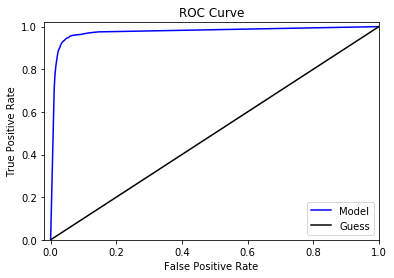

AUC = 0.975



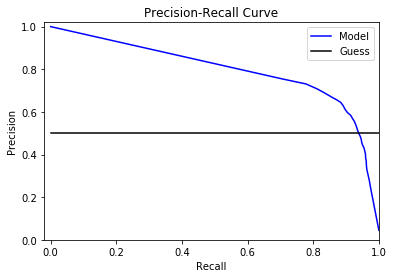

F1 Score = 0.662
AUC for Precision-Recall: 0.796
Average Precision = 0.703


In [11]:
# Check out the metrics for the bootstrap
y_prob, y_pred = boot.predict(x_test)
metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()

In [ ]:
# Single Model, all trained data
C_best = 10
gamma_best = 3
# USE THIS ONE FOR A "QUICK" RUN
model_train = SVC(C = C_best,gamma = gamma_best,max_iter =-1)
model_train.fit(x_train,y_train)
y_prob = model_train.decision_function(x_test)
y_pred = model_train.predict(x_test)
metrics_test = ModelMetrics(y_test,y_pred,y_prob)
metrics_test.all_metrics()

In [8]:
# Bootstrap plus k-folds

# K-FOLDS STUFF
metric = f1_score
C_list = [0.1,1,10]
gamma_list = [0.1,1,10]
max_iter = 7500
n_splits = 10

# BOOTSTRAP STUFF
target = 'target' # Name of target column
xlist = np.arange(1,73)           # Columns used for x

n_samples = 10000
n_models = 31
className = SVC# SVMGaussianKernelModified # (OR SVC?)
max_iter = -1 # Can be -1 for SVC?

# Create boostrap models 
boot = BootstrapKFolds(n_models = n_models, n_splits = n_splits, n_samples = n_samples,\
                metric = metric, className = className, gamma_list = gamma_list, C_list = C_list, max_iter = max_iter)
boot.fit(x_train,y_train)


TRAINING MODEL  1
C = 0.10 and gamma = 0.10
Done. "Accuracy" was 69.91%

C = 0.10 and gamma = 1.00
Done. "Accuracy" was 0.00%

C = 0.10 and gamma = 10.00
Done. "Accuracy" was 0.00%

C = 1.00 and gamma = 0.10
Done. "Accuracy" was 86.58%

C = 1.00 and gamma = 1.00
Done. "Accuracy" was 18.82%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 18.37%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 86.60%

C = 10.00 and gamma = 1.00
Done. "Accuracy" was 17.35%

C = 10.00 and gamma = 10.00
Done. "Accuracy" was 18.98%

The best value of C was  10
The best value of gamma was  0.1
TRAINING MODEL  2
C = 0.10 and gamma = 0.10
Done. "Accuracy" was 70.54%

C = 0.10 and gamma = 1.00
Done. "Accuracy" was 0.00%

C = 0.10 and gamma = 10.00
Done. "Accuracy" was 0.00%

C = 1.00 and gamma = 0.10
Done. "Accuracy" was 86.19%

C = 1.00 and gamma = 1.00
Done. "Accuracy" was 18.81%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 18.74%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 86.62%

C = 10.00 and gamm

Done. "Accuracy" was 0.00%

C = 1.00 and gamma = 0.10
Done. "Accuracy" was 87.37%

C = 1.00 and gamma = 1.00
Done. "Accuracy" was 17.21%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 17.59%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 87.61%

C = 10.00 and gamma = 1.00
Done. "Accuracy" was 17.53%

C = 10.00 and gamma = 10.00
Done. "Accuracy" was 18.20%

The best value of C was  10
The best value of gamma was  0.1
TRAINING MODEL  16
C = 0.10 and gamma = 0.10
Done. "Accuracy" was 71.90%

C = 0.10 and gamma = 1.00
Done. "Accuracy" was 0.00%

C = 0.10 and gamma = 10.00
Done. "Accuracy" was 0.00%

C = 1.00 and gamma = 0.10
Done. "Accuracy" was 86.07%

C = 1.00 and gamma = 1.00
Done. "Accuracy" was 14.74%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 15.01%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 85.91%

C = 10.00 and gamma = 1.00
Done. "Accuracy" was 15.27%

C = 10.00 and gamma = 10.00
Done. "Accuracy" was 14.95%

The best value of C was  1
The best value of gamma was  0.

Done. "Accuracy" was 19.22%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 19.12%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 85.99%

C = 10.00 and gamma = 1.00
Done. "Accuracy" was 19.17%

C = 10.00 and gamma = 10.00
Done. "Accuracy" was 18.60%

The best value of C was  1
The best value of gamma was  0.1
TRAINING MODEL  30
C = 0.10 and gamma = 0.10
Done. "Accuracy" was 71.95%

C = 0.10 and gamma = 1.00
Done. "Accuracy" was 0.00%

C = 0.10 and gamma = 10.00
Done. "Accuracy" was 0.00%

C = 1.00 and gamma = 0.10
Done. "Accuracy" was 86.69%

C = 1.00 and gamma = 1.00
Done. "Accuracy" was 19.38%

C = 1.00 and gamma = 10.00
Done. "Accuracy" was 18.99%

C = 10.00 and gamma = 0.10
Done. "Accuracy" was 86.33%

C = 10.00 and gamma = 1.00
Done. "Accuracy" was 19.56%

C = 10.00 and gamma = 10.00
Done. "Accuracy" was 19.06%

The best value of C was  1
The best value of gamma was  0.1
TRAINING MODEL  31
C = 0.10 and gamma = 0.10
Done. "Accuracy" was 73.21%

C = 0.10 and gamma = 1.00
Done. "A

PREDICTING MODEL  1
PREDICTING MODEL  2
PREDICTING MODEL  3
PREDICTING MODEL  4
PREDICTING MODEL  5
PREDICTING MODEL  6
PREDICTING MODEL  7
PREDICTING MODEL  8
PREDICTING MODEL  9
PREDICTING MODEL  10
PREDICTING MODEL  11
PREDICTING MODEL  12
PREDICTING MODEL  13
PREDICTING MODEL  14
PREDICTING MODEL  15
PREDICTING MODEL  16
PREDICTING MODEL  17
PREDICTING MODEL  18
PREDICTING MODEL  19
PREDICTING MODEL  20
PREDICTING MODEL  21
PREDICTING MODEL  22
PREDICTING MODEL  23
PREDICTING MODEL  24
PREDICTING MODEL  25
PREDICTING MODEL  26
PREDICTING MODEL  27
PREDICTING MODEL  28
PREDICTING MODEL  29
PREDICTING MODEL  30
PREDICTING MODEL  31

Number of -1 cases =  30798
Number of +1 cases =  11968
The ratio of Positve to Negative cases is 0.389

Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.


Overall Accuracy = 0.930

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |  29719  

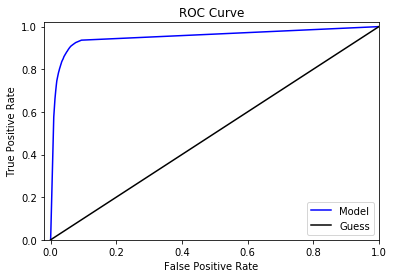

AUC = 0.952



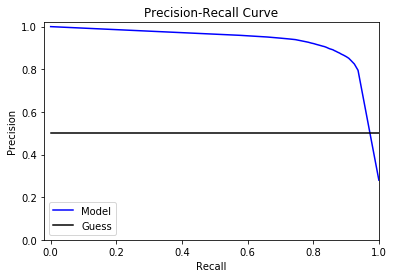

F1 Score = 0.870
AUC for Precision-Recall: 0.930
Average Precision = 0.901


In [9]:
# Check out the metrics for the bootstrap
y_prob, y_pred = boot.predict(x_test)
metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()